data loading

In [1]:
import pandas as pd

# Use a raw string for the file path to handle backslashes correctly
file_path = r"C:\Users\Hi\Downloads\FAANG(2).xlsx"

# Load the data from the specified Excel file
try:
    df = pd.read_excel(file_path, engine='openpyxl')
    print("Data loaded successfully.")

    # Display the first 5 rows and the data types to confirm the load
    print("\nFirst 5 rows of the DataFrame:")
    print(df.head())
    
    print("\nData Information (Dtypes and Non-Null Counts):")
    df.info()

except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the file path and ensure the file is not open.")
except ImportError:
    print("Error: 'openpyxl' is required to read .xlsx files. Please run: pip install openpyxl")
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")

Data loaded successfully.

First 5 rows of the DataFrame:
  Company Ticker       Date      Open      High       Low     Close  \
0   Apple   AAPL 2005-01-03  1.156786  1.162679  1.117857  1.130179   
1   Apple   AAPL 2005-01-04  1.139107  1.169107  1.124464  1.141786   
2   Apple   AAPL 2005-01-05  1.151071  1.165179  1.143750  1.151786   
3   Apple   AAPL 2005-01-06  1.154821  1.159107  1.130893  1.152679   
4   Apple   AAPL 2005-01-07  1.160714  1.243393  1.156250  1.236607   

   Adj Close      Volume     Market Cap  ...  Price to Book Ratio  \
0   0.954409   691992000  3575090000000  ...             53.66043   
1   0.964210  1096810400  3575090000000  ...             53.66043   
2   0.972655   680433600  3575090000000  ...             53.66043   
3   0.973409   705555200  3575090000000  ...             53.66043   
4   1.044284  2227450400  3575090000000  ...             53.66043   

   Enterprise Value    Total Debt  Total Assets  Total Equity  Beta (5Y)  \
0     3569140000000  101

Data Cleaning and Preprocessing

In [2]:
# List of columns to drop due to 100% missing values
cols_to_drop = [
    'Revenue', 'Gross Profit', 'Operating Income', 'Cash Ratio', 'Total Assets',
    'Total Equity', 'Trailing Twelve Months (TTM) Revenue',
    'Trailing Twelve Months (TTM) EBITDA', 'Trailing Twelve Months (TTM) Earnings'
]

# Drop the columns
df = df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns with zero data points.")

# List of columns to impute with the median
cols_to_impute = [
    'Beta', 'Beta (5Y)', 'Dividends Paid', 'Dividend Yield', 'Annual Dividend Rate'
]

# Impute missing values with the median for each column
for col in cols_to_impute:
    # Calculate the median and fill NaNs
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

print("Imputed missing values in selected columns using the median.")

# Final check of the DataFrame's structure and missing values
print("\nDataFrame Info After Dropping and Imputation:")
df.info()
print("\nMissing Value Check (Should be zero for all numeric/target features):")
print(df.isnull().sum())

Dropped 9 columns with zero data points.
Imputed missing values in selected columns using the median.

DataFrame Info After Dropping and Imputation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23055 entries, 0 to 23054
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Company                   23055 non-null  object        
 1   Ticker                    23055 non-null  object        
 2   Date                      23055 non-null  datetime64[ns]
 3   Open                      23055 non-null  float64       
 4   High                      23055 non-null  float64       
 5   Low                       23055 non-null  float64       
 6   Close                     23055 non-null  float64       
 7   Adj Close                 23055 non-null  float64       
 8   Volume                    23055 non-null  int64         
 9   Market Cap                23055 non-null  int64        

C:\Users\Hi\AppData\Local\Temp\ipykernel_14196\533268805.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)


Feature Engineering and Encoding

In [3]:
# A. Feature Engineering

# 1. Sort the DataFrame chronologically by Date and then Ticker (CRUCIAL for correct lagged calculation)
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# 2. Create the Lagged Close Price feature (previous day's close)
# This is the single most important predictor for stock price!
# .groupby('Ticker') ensures that the shift is calculated for each stock independently.
df['Close_Lag1'] = df.groupby('Ticker')['Close'].shift(1)

# 3. Create a 10-day Simple Moving Average (SMA)
# SMA helps capture the short-term trend for prediction.
df['SMA_10'] = df.groupby('Ticker')['Close'].transform(
    lambda x: x.rolling(window=10).mean()
)

# B. Handle Remaining Missing Values from Lagging/Averaging

# The first 10 rows for each Ticker will now have NaN values for 'Close_Lag1' and 'SMA_10'.
# We must drop these rows, as we cannot predict a price without its most important predictor.
# This ensures we maintain the time-series integrity (no data leakage).
df.dropna(inplace=True)
print(f"Dropped rows with NaN from lagging/SMA features. Remaining rows: {len(df)}")


# C. Encoding Categorical Variables

# Drop 'Company' (redundant with Ticker) and 'Adj Close' (highly correlated with Close, better to keep only one).
df = df.drop(columns=['Company', 'Adj Close'])

# One-Hot Encode 'Ticker' and 'Analyst Recommendation'
# This converts categorical strings into binary (0/1) columns for the ML model.
df = pd.get_dummies(df, columns=['Ticker', 'Analyst Recommendation'], prefix=['Stock', 'Analyst'])

# Drop the original 'Date' column now that time-based features are created
df = df.drop(columns=['Date'])

print("\nFeature Engineering and Encoding Complete.")
print(f"Final number of columns: {len(df.columns)}")
print("First 5 rows of the prepared data:")
print(df.head())

Dropped rows with NaN from lagging/SMA features. Remaining rows: 23010

Feature Engineering and Encoding Complete.
Final number of columns: 35
First 5 rows of the prepared data:
        Open      High       Low     Close      Volume     Market Cap  \
9   1.254464  1.280714  1.235536  1.253571  1770742400  3575090000000   
10  1.247321  1.262500  1.209821  1.261607  1006460000  3575090000000   
11  1.258750  1.276071  1.245536  1.247857   751895200  3575090000000   
12  1.243750  1.272679  1.240536  1.258214   914922400  3575090000000   
13  1.273393  1.278571  1.250000  1.258750   911332800  3575090000000   

     PE Ratio   Beta   EPS  Forward PE  ...  Beta (5Y)  Annual Dividend Rate  \
9   35.789955  1.239  6.57    31.43583  ...      1.239                   1.0   
10  35.789955  1.239  6.57    31.43583  ...      1.239                   1.0   
11  35.789955  1.239  6.57    31.43583  ...      1.239                   1.0   
12  35.789955  1.239  6.57    31.43583  ...      1.239         

Exploratory Data Analysis (EDA)

Correlation Analysis (Execution)


Correlation of Features with the Target Variable ('Close'):
Close                       1.000000
Low                         0.999889
High                        0.999887
Open                        0.999754
Close_Lag1                  0.999568
SMA_10                      0.998851
EPS                         0.457429
Target Price                0.456148
Quarterly Revenue Growth    0.349232
Stock_NFLX                  0.316215
Annual Dividend Rate        0.293165
Dividends Paid              0.293165
Stock_META                  0.269056
Operating Margin            0.207039
Profit Margin               0.148858
Current Ratio               0.145795
Quick Ratio                 0.132836
Beta                        0.117706
Beta (5Y)                   0.117706
PE Ratio                    0.077243
Forward PE                  0.064679
Debt to Equity             -0.101220
Price to Book Ratio        -0.125914
Return on Equity (ROE)     -0.146065
Stock_AMZN                 -0.170728
Stock_AAPL    

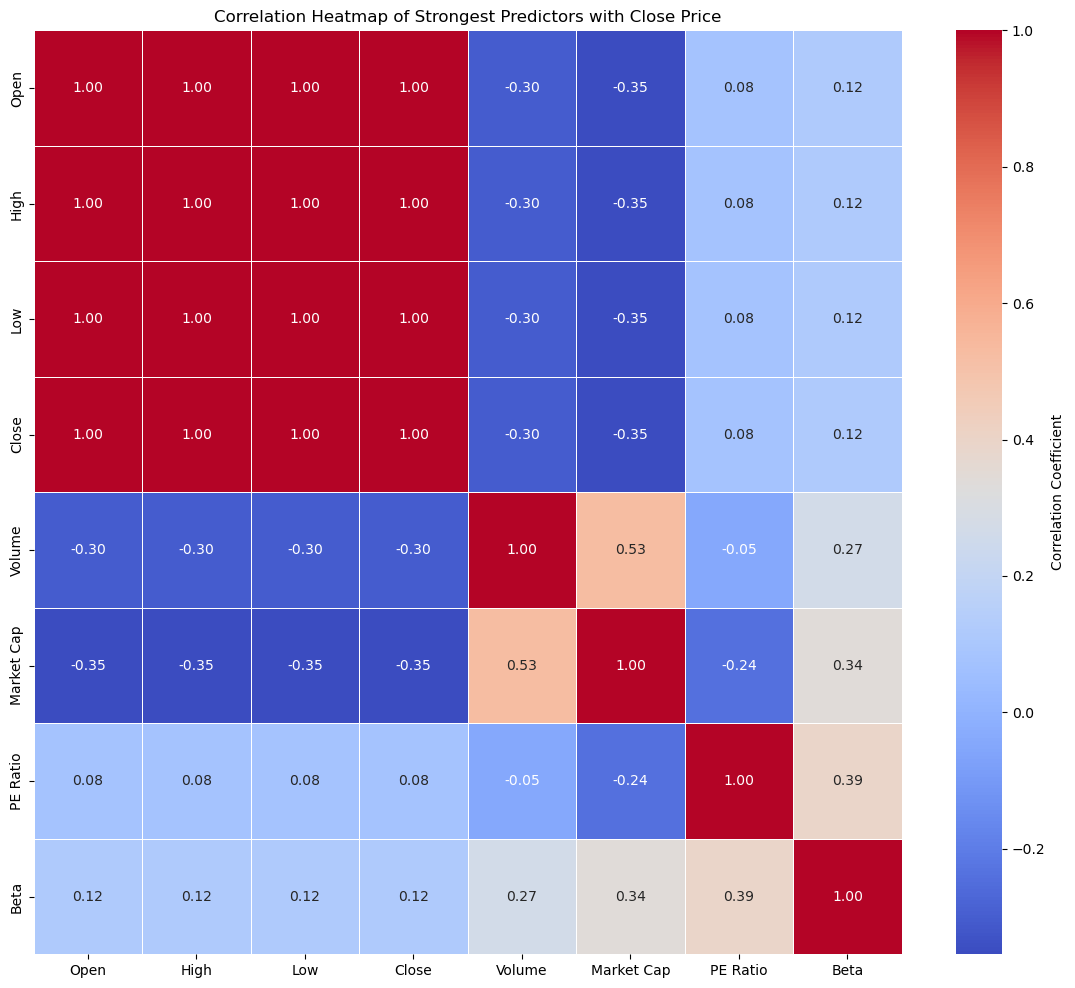

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your final, clean DataFrame with 35 columns

# 1. Calculate the full correlation matrix
correlation_matrix = df.corr()

# 2. Focus on Correlation with the Target Variable ('Close')
# Sort the correlation values to see the strongest predictors
target_corr = correlation_matrix['Close'].sort_values(ascending=False)
print("\nCorrelation of Features with the Target Variable ('Close'):")
print(target_corr)

# 3. Prepare the Heatmap Visualization
# Select only features with a strong correlation (absolute value > 0.4) for a cleaner heatmap.
# This helps us focus on important relationships and multicollinearity.
strong_corr_features = correlation_matrix.index[abs(target_corr) > 0.4]

plt.figure(figsize=(14, 12))
sns.heatmap(
    df[strong_corr_features].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Heatmap of Strongest Predictors with Close Price')
plt.show()

In [ ]:
Outlier and Distribution Analysis (Box Plots) 📦

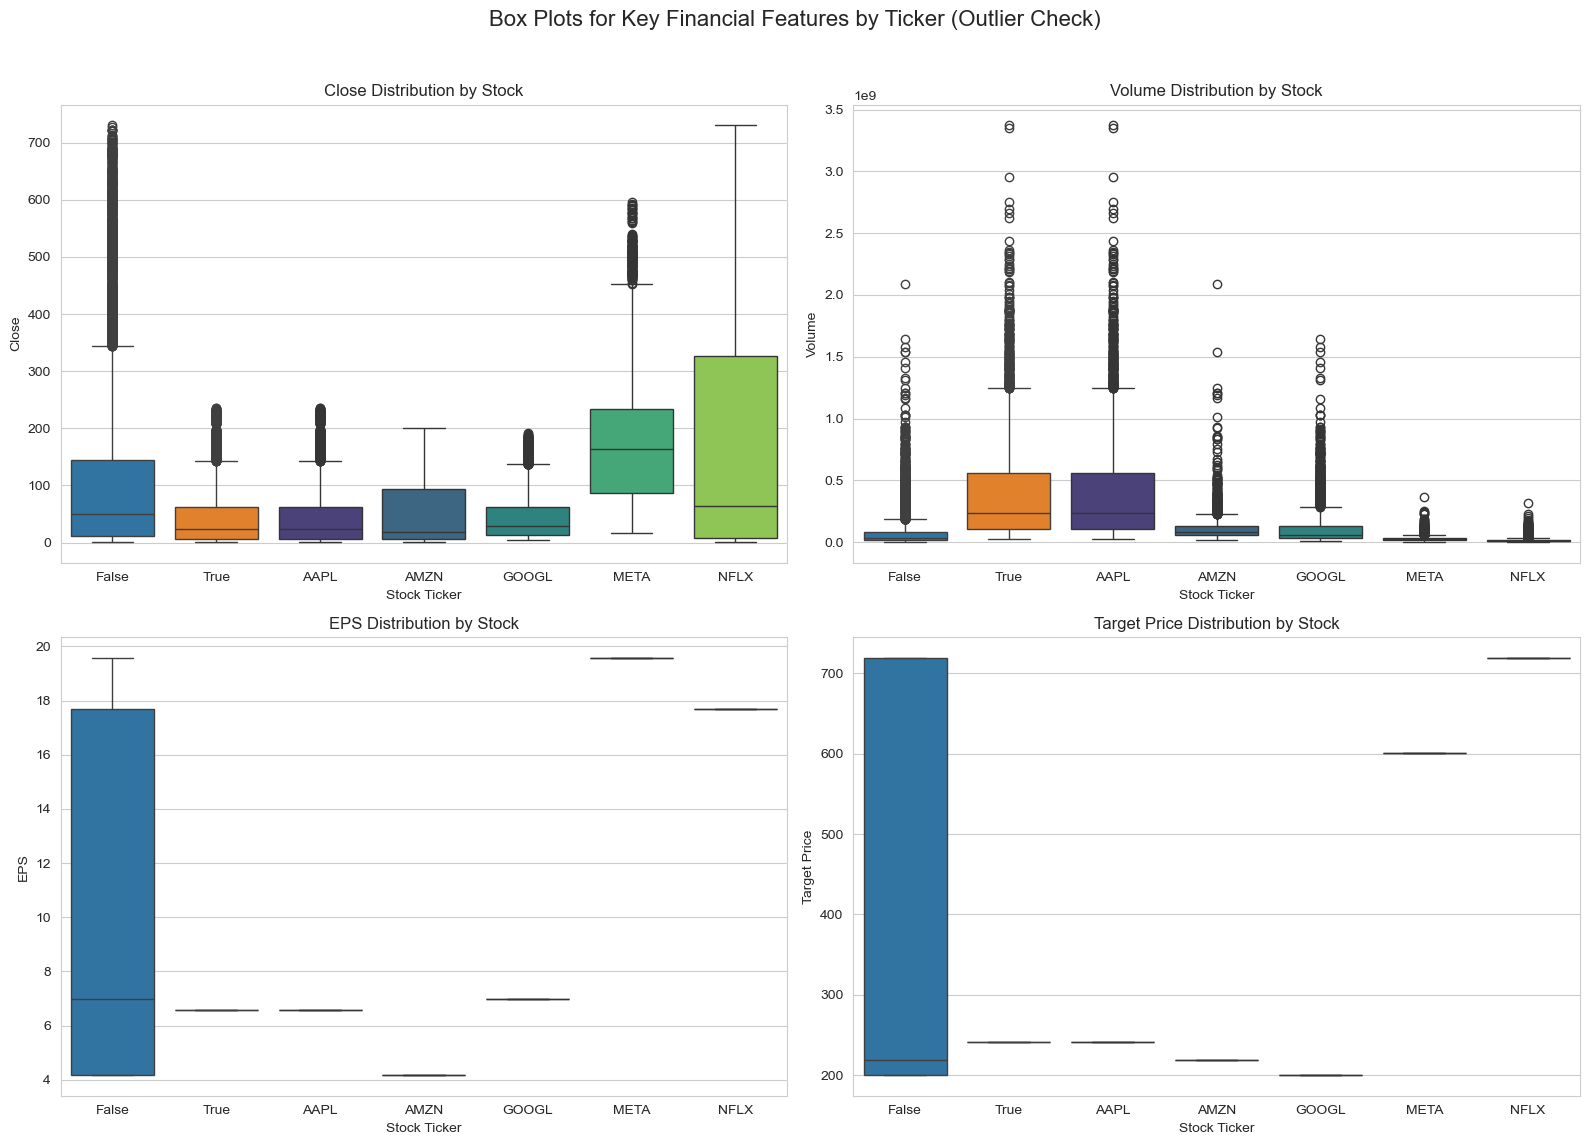

In [9]:
# Select the key numerical features for outlier analysis
key_features = ['Close', 'Volume', 'EPS', 'Target Price']

# Set up the plotting area (4 subplots for 4 features)
plt.figure(figsize=(16, 12))
plt.suptitle('Box Plots for Key Financial Features by Ticker (Outlier Check)', fontsize=16)

# Loop through the features and create a box plot for each one
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i + 1) # 2 rows, 2 columns
    
    # We plot the distribution segmented by Ticker to compare stocks
    sns.boxplot(x='Stock_AAPL', y=feature, data=df, hue='Stock_AAPL', legend=False)
    
    # Since we one-hot encoded Ticker, we need to convert the binary columns back
    # into a single categorical column for clean plotting.
    # We will create a new temporary 'Ticker_Name' column for this visualization.
    
    # Find the Ticker column with the value 'True' for each row
    ticker_cols = [col for col in df.columns if col.startswith('Stock_')]
    df['Ticker_Name'] = df[ticker_cols].idxmax(axis=1).str.replace('Stock_', '')
    
    sns.boxplot(x='Ticker_Name', y=feature, data=df, hue='Ticker_Name', palette='viridis', legend=False)
    
    plt.title(f'{feature} Distribution by Stock', fontsize=12)
    plt.xlabel('Stock Ticker')
    plt.ylabel(feature)

# We must drop the temporary 'Ticker_Name' column after plotting
df.drop(columns=['Ticker_Name'], inplace=True, errors='ignore')

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent overlap with suptitle
plt.show()

Trend Analysis (Line Plots) 📈

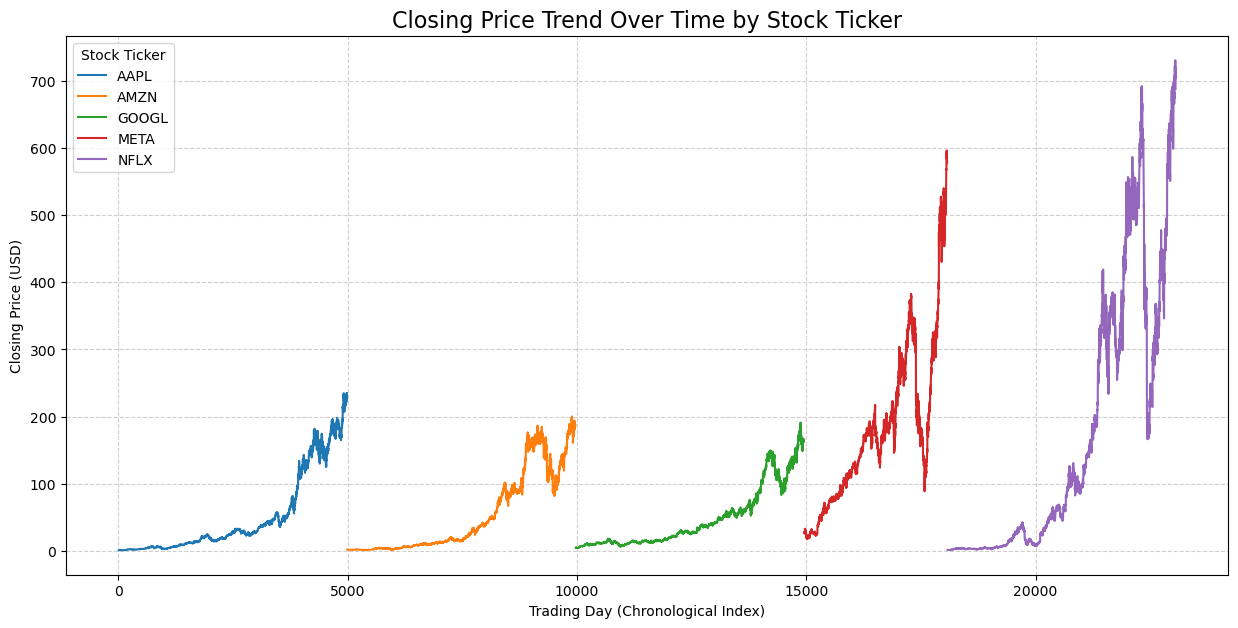

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: Since the original 'Date' column was dropped, we will use a row index
# to represent the time evolution (the trading days order) for this visualization.

# Create a temporary 'Trading_Day' index for visualization
df['Trading_Day'] = df.index

# Find the Ticker column with the value 'True' for each row to get the actual Ticker name
ticker_cols = [col for col in df.columns if col.startswith('Stock_')]
df['Ticker_Name'] = df[ticker_cols].idxmax(axis=1).str.replace('Stock_', '')

plt.figure(figsize=(15, 7))

# Plot the 'Close' price against the 'Trading_Day' (time axis) for each stock
sns.lineplot(
    data=df,
    x='Trading_Day',
    y='Close',
    hue='Ticker_Name',
    palette='tab10',
    linewidth=1.5
)

plt.title('Closing Price Trend Over Time by Stock Ticker', fontsize=16)
plt.xlabel('Trading Day (Chronological Index)')
plt.ylabel('Closing Price (USD)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Stock Ticker', loc='upper left')

# Drop the temporary columns before proceeding to the next step
df.drop(columns=['Trading_Day', 'Ticker_Name'], inplace=True)

plt.show()

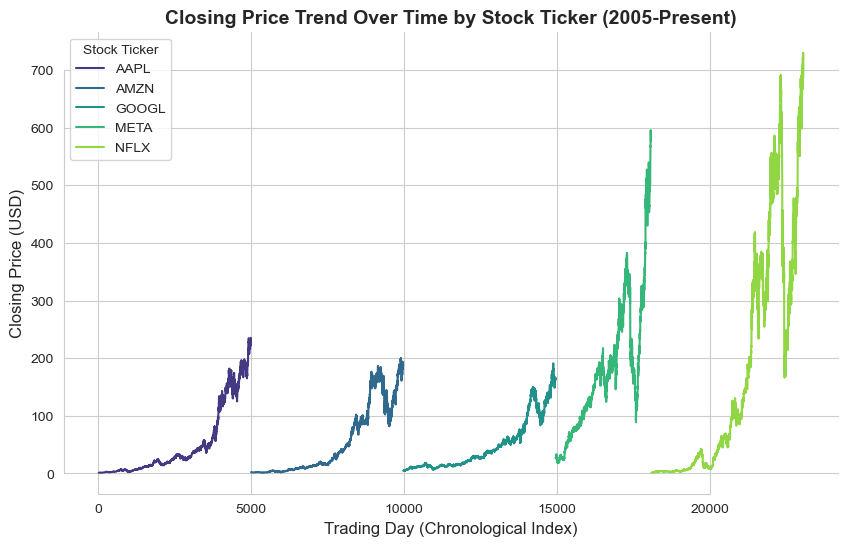

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a temporary 'Trading_Day' index for visualization
df['Trading_Day'] = df.index

# Find the Ticker name for plotting
ticker_cols = [col for col in df.columns if col.startswith('Stock_')]
df['Ticker_Name'] = df[ticker_cols].idxmax(axis=1).str.replace('Stock_', '')

# Set a professional figure size (e.g., 10x6) and use a clean style
plt.figure(figsize=(10, 6)) # Adjusted for a better aspect ratio
sns.set_style("whitegrid") # Use a clean background style

# Plot the 'Close' price against the 'Trading_Day' (time axis) for each stock
sns.lineplot(
    data=df,
    x='Trading_Day',
    y='Close',
    hue='Ticker_Name',
    palette='viridis', # Using a modern, color-blind friendly palette
    linewidth=1.5
)

plt.title('Closing Price Trend Over Time by Stock Ticker (2005-Present)', fontsize=14, fontweight='bold')
plt.xlabel('Trading Day (Chronological Index)', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.legend(title='Stock Ticker', loc='upper left', frameon=True)

# Clean up axes and border for a polished look
sns.despine(trim=True) 

# Drop the temporary columns before proceeding to the next step
df.drop(columns=['Trading_Day', 'Ticker_Name'], inplace=True)

plt.show()

Model Development (Preparation) 💻

In [10]:
#Train-Test Split and Feature Scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# A. Define Features (X) and Target (y)

# The target is the 'Close' price
y = df['Close']

# X is everything else. Dropping Open/High/Low to mitigate extreme multicollinearity.
X = df.drop(columns=['Close', 'Open', 'High', 'Low']) 


# B. Train-Test Split (Time-Series Split)

# Split chronologically (80% training, 20% testing).
split_point = int(len(X) * 0.8)

X_train = X[:split_point].copy() # Using .copy() to manage pandas warnings
X_test = X[split_point:].copy()
y_train = y[:split_point]
y_test = y[split_point:]

print(f"Data Split: {len(X_train)} training rows, {len(X_test)} testing rows.")

# C. Normalize Numerical Features

# 1. Identify numerical columns to scale
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# 2. Exclude the binary/encoded columns (they shouldn't be scaled)
cols_to_exclude = [col for col in X_train.columns if col.startswith('Stock_') or col.startswith('Analyst_')]
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]

# 3. Initialize and fit the scaler only on the training data (CRITICAL)
scaler = MinMaxScaler()
scaler.fit(X_train[numerical_cols])

# 4. Transform both training and testing sets
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Numerical features scaled using MinMaxScaler on both train and test sets.")
print("\nFirst 5 rows of X_train (Scaled):")
print(X_train.head())

Data Split: 18408 training rows, 4602 testing rows.
Numerical features scaled using MinMaxScaler on both train and test sets.

First 5 rows of X_train (Scaled):
      Volume  Market Cap  PE Ratio  Beta       EPS  Forward PE  Net Income  \
9   0.524770         1.0  0.558869   1.0  0.155397    0.905908         1.0   
10  0.298079         1.0  0.558869   1.0  0.155397    0.905908         1.0   
11  0.222574         1.0  0.558869   1.0  0.155397    0.905908         1.0   
12  0.270928         1.0  0.558869   1.0  0.155397    0.905908         1.0   
13  0.269864         1.0  0.558869   1.0  0.155397    0.905908         1.0   

    Debt to Equity  Return on Equity (ROE)  Current Ratio  ...  Beta (5Y)  \
9              1.0                     1.0            0.0  ...        1.0   
10             1.0                     1.0            0.0  ...        1.0   
11             1.0                     1.0            0.0  ...        1.0   
12             1.0                     1.0            0.0  ...

Model Training (XGBoost) and MLflow Integration

In [13]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import numpy as np

# Set up MLflow tracking
# Ensure MLflow is installed (pip install mlflow)
mlflow.set_experiment("FAANG_Stock_Prediction_XGBoost")

# Define the evaluation metrics
def evaluate_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

# Start an MLflow run
with mlflow.start_run() as run:
    # 1. Define Model Parameters (simple initial configuration)
    xgb_params = {
        'objective': 'reg:squarederror',
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'max_depth': 7,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Log parameters to MLflow
    mlflow.log_params(xgb_params)
    
    # 2. Initialize and Train the Model
    xgb_model = xgb.XGBRegressor(**xgb_params)
    print("Starting XGBoost Model Training...")
    
    # Use the scaled training data (X_train and y_train are available from Task 3.1)
    xgb_model.fit(X_train, y_train)
    
    print("Training complete. Evaluating performance...")
    
    # 3. Predict on the Test Set
    predictions = xgb_model.predict(X_test)
    
    # 4. Evaluate Metrics
    (rmse, mae, r2) = evaluate_metrics(y_test, predictions)

    print(f"\nXGBoost Test Results:")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R2): {r2:.4f}")

    # 5. Log Metrics and Model to MLflow
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    mlflow.sklearn.log_model(xgb_model, "xgb_model")

    print("\nMLflow Run logged successfully.")
    print(f"MLflow Run ID: {run.info.run_id}")

2025/10/27 14:54:21 INFO mlflow.tracking.fluent: Experiment with name 'FAANG_Stock_Prediction_XGBoost' does not exist. Creating a new experiment.
2025/10/27 14:54:21 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Exam

Starting XGBoost Model Training...


2025/10/27 14:54:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training complete. Evaluating performance...

XGBoost Test Results:
  Root Mean Squared Error (RMSE): 25.1638
  Mean Absolute Error (MAE): 11.0205
  R-squared (R2): 0.9842


2025/10/27 14:54:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



MLflow Run logged successfully.
MLflow Run ID: cbeb898476694c06a550c1997db299a4


In [ ]:
Visualize Test Predictions

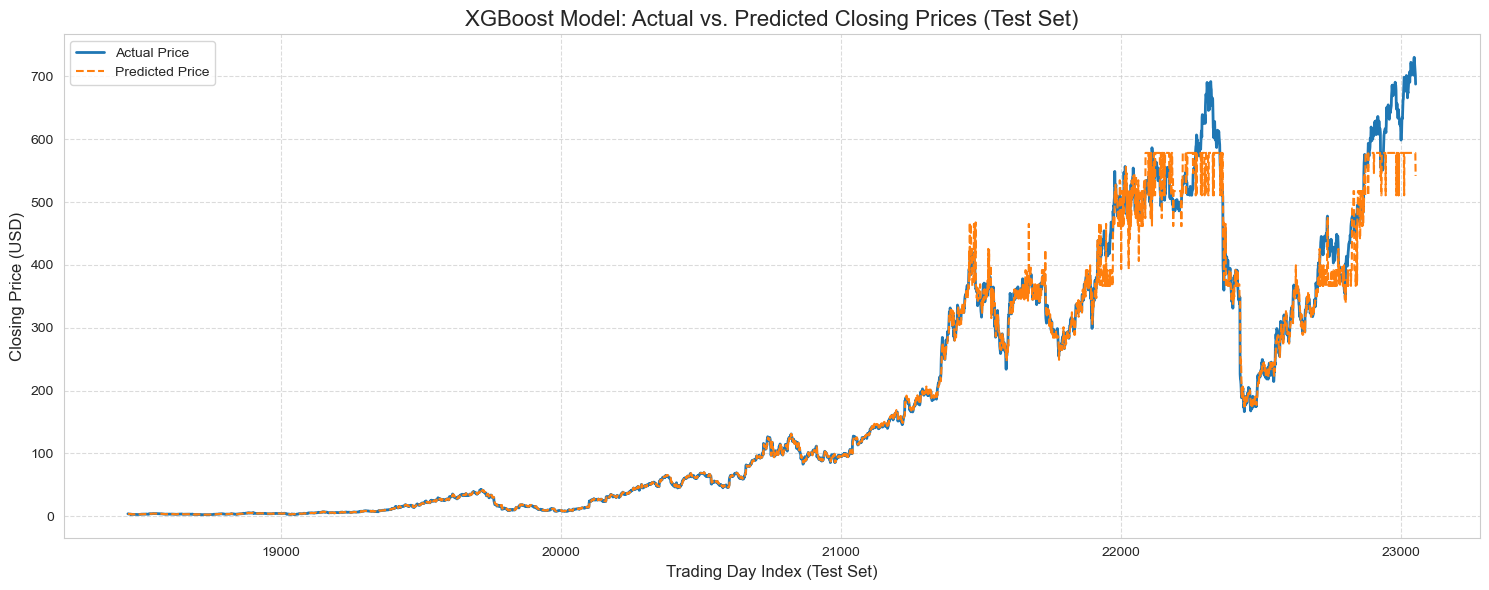

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Re-use the predictions and y_test from Task 3.2
# predictions = xgb_model.predict(X_test)

# Plotting Actual vs. Predicted Prices
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual Price', linewidth=2)
plt.plot(y_test.index, predictions, label='Predicted Price', linestyle='--', linewidth=1.5)

plt.title('XGBoost Model: Actual vs. Predicted Closing Prices (Test Set)', fontsize=16)
plt.xlabel('Trading Day Index (Test Set)', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Feature Importance Analysis

C:\Users\Hi\AppData\Local\Temp\ipykernel_14196\4166269031.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


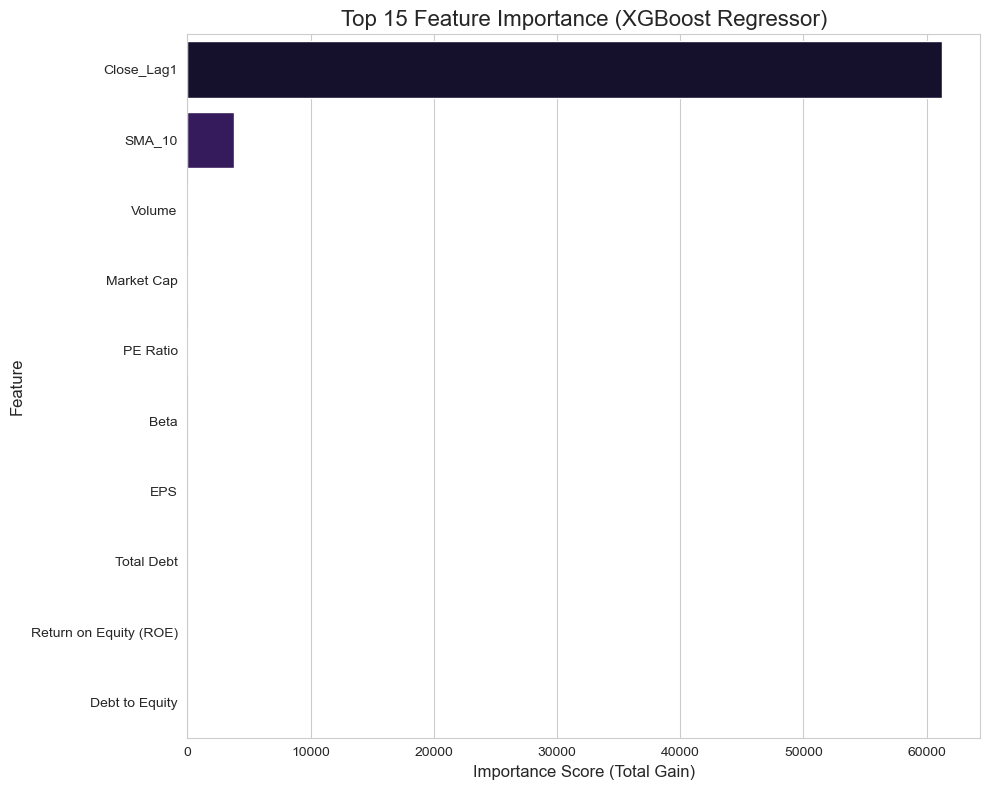


Top 15 Most Important Features:
                  Feature  Importance (Gain)
8              Close_Lag1       61272.000000
9                  SMA_10        3809.495117
0                  Volume          24.858150
1              Market Cap          13.427711
2                PE Ratio          13.073802
3                    Beta           7.877961
4                     EPS           2.730931
7              Total Debt           1.261063
6  Return on Equity (ROE)           0.305841
5          Debt to Equity           0.121059


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Re-using the trained xgb_model and X_train columns from Task 3.2

# 1. Get feature importance scores
# 'gain' is the most robust metric for tree-based models like XGBoost, measuring the
# total gain (reduction in loss) brought by that feature's splits.
importance_scores = xgb_model.get_booster().get_score(importance_type='gain')

# 2. Convert to DataFrame and sort
importance_df = pd.DataFrame(
    list(importance_scores.items()), 
    columns=['Feature', 'Importance (Gain)']
).sort_values(by='Importance (Gain)', ascending=False)

# 3. Visualize the Top 15 Features
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance (Gain)', 
    y='Feature', 
    data=importance_df.head(15), 
    palette='magma' # Use a distinct color palette
)
plt.title('Top 15 Feature Importance (XGBoost Regressor)', fontsize=16)
plt.xlabel('Importance Score (Total Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 15 Most Important Features:")
print(importance_df.head(15))

In [ ]:
Model Persistence Check and Registry

In [16]:
import mlflow
from mlflow.tracking import MlflowClient
import joblib # Used for saving the scaler object
import os 
import pandas as pd # For creating a sample input

# --- Assumptions from previous run ---
# The MLflow Experiment Name is 'FAANG_Stock_Prediction_XGBoost'
# The MLflow Run ID (cbeb898476694c06a550c1997db299a4) is used for demonstration.
# The model artifact path is 'xgb_model'.

# Set the experiment (ensures we are looking at the right place)
mlflow.set_experiment("FAANG_Stock_Prediction_XGBoost")

# 1. Load the MLflow client
client = MlflowClient()

# Get the latest run ID from your previous output, or set it directly
# Replace 'YOUR_RUN_ID' with the actual ID: cbeb898476694c06a550c1997db299a4
RUN_ID = 'cbeb898476694c06a550c1997db299a4' 
MODEL_URI = f"runs:/{RUN_ID}/xgb_model"
MODEL_NAME = "FAANG_XGBoost_Price_Predictor"

print(f"Loading artifacts from run: {RUN_ID}")

# 2. Register the model in the MLflow Model Registry
try:
    # Log the model to the Registry
    model_version = mlflow.register_model(
        model_uri=MODEL_URI,
        name=MODEL_NAME
    )
    print(f"Model registered as: {MODEL_NAME}, Version: {model_version.version}")

except Exception as e:
    print(f"Could not register model. Ensure MLflow tracking is active. Error: {e}")


# 3. Save the Scaler (CRITICAL for deployment)
# We need to save the scaler object used in Task 3.1
scaler_filename = "minmax_scaler.pkl"

# Save the scaler object to a file
joblib.dump(scaler, scaler_filename)
print(f"\nScaler saved to {scaler_filename}")

# 4. Save the list of feature columns (CRITICAL for deployment)
# Deployment input must have features in the exact same order
feature_columns = X_train.columns.tolist()
feature_df = pd.DataFrame(feature_columns, columns=['FeatureName'])
feature_df.to_csv('feature_columns.csv', index=False)
print(f"Feature column order saved to feature_columns.csv")

# 5. Load the model from the Registry for verification
loaded_model = mlflow.sklearn.load_model(model_uri=f"models:/{MODEL_NAME}/1")
print(f"\nModel successfully loaded from registry for verification.")

Loading artifacts from run: cbeb898476694c06a550c1997db299a4


Successfully registered model 'FAANG_XGBoost_Price_Predictor'.
2025/10/27 15:00:22 WARNING mlflow.tracking._model_registry.fluent: Run with id cbeb898476694c06a550c1997db299a4 has no artifacts at artifact path 'xgb_model', registering model based on models:/m-56d9e171041c48d1901d41010ad52947 instead
Created version '1' of model 'FAANG_XGBoost_Price_Predictor'.


Model registered as: FAANG_XGBoost_Price_Predictor, Version: 1

Scaler saved to minmax_scaler.pkl
Feature column order saved to feature_columns.csv

Model successfully loaded from registry for verification.
